# Ejercicio 2 — EOF de SST en el Pacífico Ecuatorial

Notebook con ejemplo sintético (ejemplo_SST_EOF).

In [26]:
# Instalar cartopy si no está presente
!pip install cartopy --quiet

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import signal
import urllib.request

# URL del archivo en GitHub
url = 'https://raw.githubusercontent.com/fbecker23/TP-Oceano---Circulacion-General/main/ejercicios/ejercicio-2/ejemplo_SST_EOF.nc'

# Descargar el archivo localmente
urllib.request.urlretrieve(url, 'ejemplo_SST_EOF.nc')

# Abrir con el engine correcto
ds = xr.open_dataset('ejemplo_SST_EOF.nc', engine='scipy')

print(ds)

<xarray.Dataset> Size: 24MB
Dimensions:  (time: 276, lat: 61, lon: 181)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2003-01-01 2003-02-01 ... 2025-12-01
  * lat      (lat) int32 244B 30 29 28 27 26 25 24 ... -25 -26 -27 -28 -29 -30
  * lon      (lon) int32 724B 120 121 122 123 124 125 ... 296 297 298 299 300
Data variables:
    sst      (time, lat, lon) float64 24MB ...
Attributes:
    title:        Ejemplo sintético de SST para análisis EOF
    description:  Simulación simplificada del ENSO sobre el Pacífico ecuatori...
    units:        °C


In [27]:
# Calcular climatología mensual y anomalías
sst = ds['sst']
clim = sst.groupby('time.month').mean(dim='time')
anom = sst.groupby('time.month') - clim
ntime = anom.sizes['time']
ndata = anom.values.reshape(ntime, -1)
# simple PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pcs = pca.fit_transform(ndata)
print('Var explained:', pca.explained_variance_ratio_)

Var explained: [0.65002547 0.0017105  0.00166431]


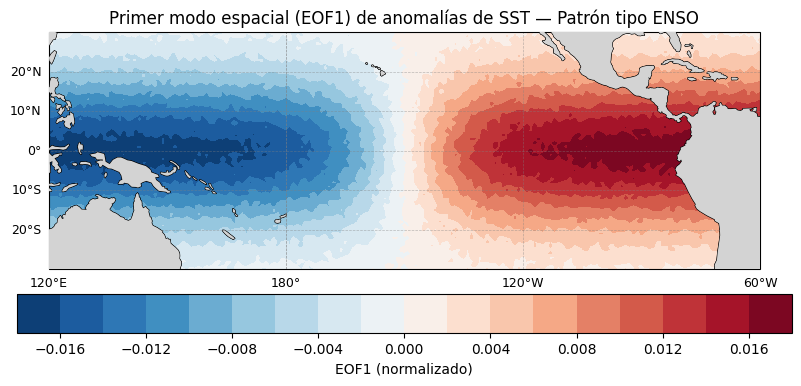

In [28]:
# Gráficos de ejemplo (EOF1 y PC1)
# Obtener el primer modo (EOF1)
eof1 = pca.components_[0, :].reshape(anom.sizes['lat'], anom.sizes['lon'])

# Crear figura con proyección geográfica
fig = plt.figure(figsize=(10,4))
proj = ccrs.PlateCarree(central_longitude=180)
ax = plt.axes(projection=proj)

# Graficar el EOF1
c = ax.contourf(ds['lon'], ds['lat'], eof1,
                transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=21)

# Agregar máscara gris semitransparente sobre tierra
land_mask = cfeature.NaturalEarthFeature(
    'physical', 'land', '110m',
    facecolor='lightgray', edgecolor='none'
)
ax.add_feature(land_mask, zorder=10, alpha=1)

# Costas y bordes
ax.coastlines(resolution='110m', color='black', linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.3, edgecolor='gray')

# Agregar detalles geográficos
ax.coastlines(resolution='110m', color='black', linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.4)
ax.set_extent([120, 300, -30, 30], crs=ccrs.PlateCarree())

# Grilla con etiquetas de lat/lon
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 9}
gl.ylabel_style = {'size': 9}

# Colorbar y título
plt.colorbar(c, orientation='horizontal', pad=0.08, label='EOF1 (normalizado)')
ax.set_title('Primer modo espacial (EOF1) de anomalías de SST — Patrón tipo ENSO')
plt.show()

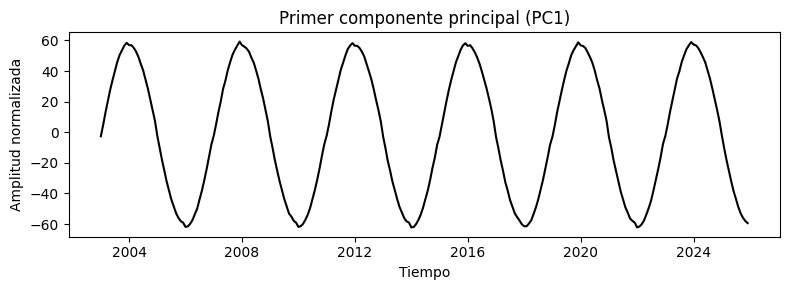

In [29]:
plt.figure(figsize=(8,3))
plt.plot(ds['time'], pcs[:,0], 'k-')
plt.title('Primer componente principal (PC1)')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud normalizada')
plt.tight_layout()
plt.show()
